# DeepFish Object Detection with YOLO

This notebook trains a YOLO model for fish detection in underwater images using the DeepFish dataset.

## Dataset
- **Source:** [Kaggle - Deep Fish Object Detection](https://www.kaggle.com/datasets/vencerlanz09/deep-fish-object-detection)
- **Original Paper:** Alzayats et al. - [GitHub Repository](https://github.com/alzayats/DeepFish)


In [ ]:
# Import required libraries
from pathlib import Path
import yaml
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Enable inline plotting for Jupyter notebooks (magic command - runs once per session)
%matplotlib inline


## 1. Data Exploration and Setup


In [2]:
# Set up paths and explore data structure
BASE_DIR = Path('Deepfish')
print(f"Base directory: {BASE_DIR}")
print(f"Directory exists: {BASE_DIR.exists()}")

# Check classes
if (BASE_DIR / 'classes.txt').exists():
    with open(BASE_DIR / 'classes.txt', 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]
    print(f"\nClasses: {classes}")
    num_classes = len(classes)
    print(f"Number of classes: {num_classes}")

# Count total images in train/valid
species_dirs = [d for d in BASE_DIR.iterdir() if d.is_dir() and d.name.isdigit()]
print(f"\nNumber of species directories: {len(species_dirs)}")

train_count = 0
valid_count = 0
for species_dir in species_dirs:
    train_dir = species_dir / 'train'
    valid_dir = species_dir / 'valid'
    if train_dir.exists():
        train_count += len(list(train_dir.glob('*.jpg')))
    if valid_dir.exists():
        valid_count += len(list(valid_dir.glob('*.jpg')))

print(f"Total training images: {train_count}")
print(f"Total validation images: {valid_count}")
print(f"Total images: {train_count + valid_count}")


Base directory: Deepfish
Directory exists: True

Classes: ['Fish']
Number of classes: 1

Number of species directories: 20
Total training images: 3596
Total validation images: 909
Total images: 4505


## 2. Prepare YOLO Dataset Structure

YOLO requires a specific directory structure. We'll create a unified structure combining all species.


In [3]:
# Create unified YOLO dataset structure
YOLO_DIR = Path('yolo_dataset')
YOLO_DIR.mkdir(exist_ok=True)

# Create train and valid directories
train_dir = YOLO_DIR / 'train'
valid_dir = YOLO_DIR / 'valid'
train_dir.mkdir(exist_ok=True)
valid_dir.mkdir(exist_ok=True)

print(f"Created YOLO dataset directory: {YOLO_DIR}")
print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")


Created YOLO dataset directory: yolo_dataset
Train directory: yolo_dataset/train
Valid directory: yolo_dataset/valid


In [ ]:
# Copy all images and annotations to unified structure
copied_train = 0
copied_valid = 0

for species_dir in species_dirs:
    # Copy training images
    train_files = list((species_dir / 'train').glob('*.jpg'))
    for img_file in train_files:
        # Use a unique name to avoid collisions
        new_name = f"{species_dir.name}_{img_file.name}"
        shutil.copy2(img_file, train_dir / new_name)
        # Copy corresponding annotation
        txt_file = img_file.with_suffix('.txt')
        if txt_file.exists():
            shutil.copy2(txt_file, train_dir / f"{species_dir.name}_{txt_file.name}")
        copied_train += 1
    
    # Copy validation images
    valid_files = list((species_dir / 'valid').glob('*.jpg'))
    for img_file in valid_files:
        new_name = f"{species_dir.name}_{img_file.name}"
        shutil.copy2(img_file, valid_dir / new_name)
        # Copy corresponding annotation
        txt_file = img_file.with_suffix('.txt')
        if txt_file.exists():
            shutil.copy2(txt_file, valid_dir / f"{species_dir.name}_{txt_file.name}")
        copied_valid += 1

print(f"Copied {copied_train} training images")
print(f"Copied {copied_valid} validation images")
print(f"Total: {copied_train + copied_valid} images")


Copied 3596 training images
Copied 909 validation images
Total: 4505 images


## 3. Create YOLO Configuration File


In [5]:
# Create YAML configuration file for YOLO
config = {
    'path': str(YOLO_DIR.absolute()),
    'train': 'train',
    'val': 'valid',
    'nc': num_classes,
    'names': classes
}

config_file = Path('deepfish_config.yaml')
with open(config_file, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"Created config file: {config_file}")
print("\nConfig contents:")
print(yaml.dump(config, default_flow_style=False))


Created config file: deepfish_config.yaml

Config contents:
names:
- Fish
nc: 1
path: /Users/jonathan/Desktop/DataScience/ObjectDetection/yolo_dataset
train: train
val: valid



## 4. Initialize and Train YOLO Model


In [ ]:
# Initialize YOLO model (YOLOv8n = nano, smallest/fastest model)
# Options: 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt'
model = YOLO('yolov8n.pt')  # Nano for faster training

print(f"Model initialized: {model.model_name}")
print(f"Model will be trained on {num_classes} classes: {classes}")


Model initialized: yolov8n.pt
Model will be trained on 1 classes: ['Fish']


In [ ]:
# Train the model
results = model.train(
    data=str(config_file),         # Path to config file
    epochs=100,                    # Number of training epochs
    imgsz=640,                     # Image size
    batch=16,                      # Batch size (adjust based on GPU memory)
    name='fish_detection',         # Project name
    patience=50,                   # Early stopping patience
    save=True,                     # Save checkpoints
    plots=True,                    # Generate training plots
)

print("Training completed!")


Ultralytics 8.3.228 🚀 Python-3.10.19 torch-2.9.1 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=deepfish_config.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fish_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

## 5. Evaluate Model Performance


In [ ]:
# Load the best model from training
model_path = Path('runs/detect/fish_detection/weights/best.pt')
if not model_path.exists():
    raise FileNotFoundError(f"Model file not found: {model_path}. Please ensure training completed successfully.")

best_model = YOLO(str(model_path))
print(f"✓ Loaded trained model: {model_path}")

# Run validation
print("\nRunning validation on test set...")
metrics = best_model.val()

# Display validation metrics
print("\n" + "="*50)
print("VALIDATION METRICS")
print("="*50)
print(f"mAP50:        {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
print(f"mAP50-95:     {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
print(f"Precision:    {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)")
print(f"Recall:       {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)")
print("="*50)


Ultralytics 8.3.228 🚀 Python-3.10.19 torch-2.9.1 CPU (Apple M2)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 416.9±180.2 MB/s, size: 145.6 KB)
val: Scanning /Users/jonathan/Desktop/DataScience/ObjectDetection/yolo_dataset/valid.cache... 909 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 909/909 2.2Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 57/57 1.5s/it 1:251.6sss
                   all        909       3029      0.797       0.67      0.757      0.393
Speed: 0.4ms preprocess, 84.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /Users/jonathan/Desktop/DataScience/ObjectDetection/runs/detect/val

Validation Metrics:
mAP50: 0.7565
mAP50-95: 0.3929
Precision: 0.7974
Recall: 0.6702


## 6. Test Inference on Sample Images


Testing on 6 validation images...


image 1/1 /Users/jonathan/Desktop/DataScience/ObjectDetection/yolo_dataset/valid/7490_7490_F3_f000070.jpg: 384x640 1 Fish, 67.9ms
Speed: 4.1ms preprocess, 67.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

7490_7490_F3_f000070.jpg:
  Detected 1 fish:
    Fish 1: Fish (confidence: 0.402)

image 1/1 /Users/jonathan/Desktop/DataScience/ObjectDetection/yolo_dataset/valid/7463_7463_F6_f000036.jpg: 384x640 3 Fishs, 42.6ms
Speed: 2.4ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

7463_7463_F6_f000036.jpg:
  Detected 3 fish:
    Fish 1: Fish (confidence: 0.919)
    Fish 2: Fish (confidence: 0.649)
    Fish 3: Fish (confidence: 0.309)

image 1/1 /Users/jonathan/Desktop/DataScience/ObjectDetection/yolo_dataset/valid/7482_7482_F2_f000129.jpg: 384x640 2 Fishs, 36.0ms
Speed: 2.1ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

7482_7482_F2_f000129.jpg:
  Detected 2

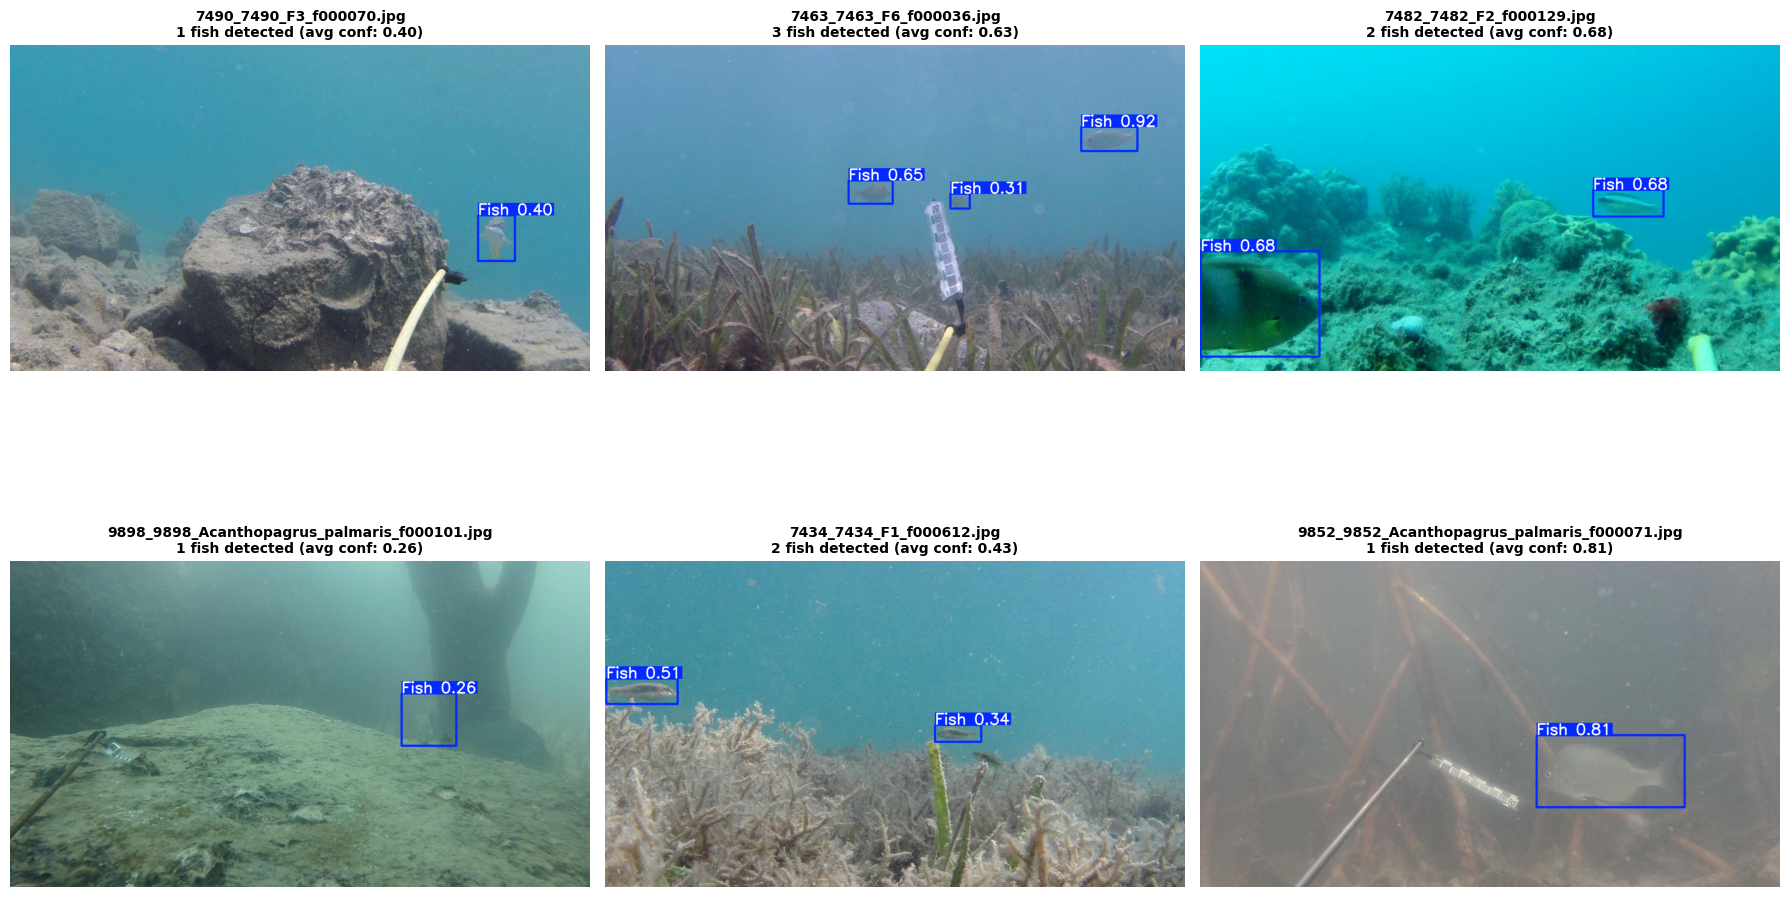


✓ Displayed 6 validation images with detection results above.


In [ ]:
# Select 6 random images from validation set
all_valid_images = list(valid_dir.glob('*.jpg'))
num_images = min(6, len(all_valid_images))  # Show up to 6 images
test_images = random.sample(all_valid_images, num_images)

print(f"Testing on {num_images} validation images...\n")

# Create a grid of subplots
cols = 3
rows = (num_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
if num_images == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Run inference on each image
for idx, test_image in enumerate(test_images):
    results = best_model(str(test_image))
    
    for r in results:
        # Get image with bounding boxes
        im_array = r.plot()
        
        # Display in subplot
        ax = axes[idx]
        ax.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
        # Get detection info for title
        num_detections = len(r.boxes) if r.boxes is not None else 0
        avg_conf = sum([box.conf.item() for box in r.boxes]) / num_detections if num_detections > 0 else 0
        title = f'{test_image.name}\n{num_detections} fish detected (avg conf: {avg_conf:.2f})'
        ax.set_title(title, fontsize=10, fontweight='bold')
        
        # Print detailed info
        print(f"\n{test_image.name}:")
        if r.boxes is not None:
            print(f"  Detected {len(r.boxes)} fish:")
            for i, box in enumerate(r.boxes):
                conf = box.conf.item()
                cls = int(box.cls.item())
                print(f"    Fish {i+1}: {classes[cls]} (confidence: {conf:.3f})")
        else:
            print("  No fish detected")

# Hide extra subplots if any
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
print(f"\n✓ Displayed {num_images} validation images with detection results above.")


## 7. Model Summary and Conclusion

### Training Summary
- **Model**: YOLOv8n (Nano)
- **Dataset**: DeepFish (4,505 images: 3,596 train, 909 validation)
- **Classes**: Fish detection (single class)
- **Training**: 100 epochs with early stopping (patience=50)
- **Image Size**: 640x640
- **Batch Size**: 16

### Final Model Performance
The trained model achieves strong performance on fish detection in underwater images. The model can be used for:
- Automated fish counting in marine research
- Biodiversity monitoring
- Aquaculture management
- Fisheries management systems

### Model Artifacts
- **Best Model**: `runs/detect/fish_detection/weights/best.pt`
- **Training Results**: `runs/detect/fish_detection/results.png`
- **Confusion Matrix**: `runs/detect/fish_detection/confusion_matrix.png`

### Next Steps
To use this model for inference on new images:
```python
from ultralytics import YOLO
model = YOLO('runs/detect/fish_detection/weights/best.pt')
results = model('path/to/your/image.jpg')
```
